# NOTEBOOK 01: DATA EXPLORATION
## Zebrafish Embryo PSM Segmentation Project - CS-433 EPFL

This notebook performs comprehensive data exploration to understand:
- Image dimensions and data types
- Intensity distributions per channel
- Artifacts (stripes, uneven illumination, drift)
- Differences between datasets (normal vs HIGHRES)
- Optimal preprocessing strategies



In [1]:
# =============================================================================
# CELL 1: IMPORTS AND CONFIGURATION
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
from tifffile import imread, TiffFile
import xml.etree.ElementTree as ET
from typing import Dict, List, Tuple, Optional
import warnings
from dataclasses import dataclass
from collections import defaultdict
import gc
from scipy import ndimage as ndi

# Configure matplotlib
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['image.cmap'] = 'gray'
warnings.filterwarnings('ignore')

print("Imports loaded successfully")
print(f"NumPy version: {np.__version__}")


Imports loaded successfully
NumPy version: 2.2.6


In [2]:
# =============================================================================
# CELL 2: DATA CLASSES AND UTILITY FUNCTIONS
# =============================================================================

@dataclass
class DatasetInfo:
    """Container for dataset metadata."""
    name: str
    path: Path
    n_channels: int
    n_timepoints: int
    size_z: int
    size_y: int
    size_x: int
    physical_size_xy: float  # µm/pixel
    physical_size_z: float   # µm between slices
    time_increment: float    # seconds between frames
    dtype: str
    
    @property
    def voxel_volume_um3(self) -> float:
        """Volume of a single voxel in cubic micrometers."""
        return self.physical_size_xy * self.physical_size_xy * self.physical_size_z
    
    @property
    def anisotropy_ratio(self) -> float:
        """Z/XY resolution ratio (higher = more anisotropic)."""
        return self.physical_size_z / self.physical_size_xy
    
    def __repr__(self) -> str:
        return f"""
DatasetInfo: {self.name}
  Path: {self.path}
  Channels: {self.n_channels}
  Timepoints: {self.n_timepoints}
  Shape (Z,Y,X): ({self.size_z}, {self.size_y}, {self.size_x})
  Resolution XY: {self.physical_size_xy} µm/px
  Resolution Z: {self.physical_size_z} µm
  Anisotropy: {self.anisotropy_ratio:.2f}x
  Time increment: {self.time_increment}s
  Dtype: {self.dtype}
"""


def parse_ome_metadata(ome_path: Path) -> Dict:
    """
    Parse OME-XML metadata file to extract physical dimensions.
    
    Args:
        ome_path: Path to ome-tiff.companion.ome file
        
    Returns:
        Dictionary with physical sizes and other metadata
    """
    metadata = {
        'physical_size_x': 0.347,
        'physical_size_y': 0.347,
        'physical_size_z': 2.0,
        'time_increment': 120.0,
        'size_x': 2304,
        'size_y': 2304,
        'size_z': 151,
        'size_c': 4,
        'size_t': 16
    }
    
    try:
        tree = ET.parse(ome_path)
        root = tree.getroot()
        
        # Find Pixels element (handle namespaces)
        for elem in root.iter():
            if 'Pixels' in elem.tag:
                if 'PhysicalSizeX' in elem.attrib:
                    metadata['physical_size_x'] = float(elem.attrib['PhysicalSizeX'])
                if 'PhysicalSizeY' in elem.attrib:
                    metadata['physical_size_y'] = float(elem.attrib['PhysicalSizeY'])
                if 'PhysicalSizeZ' in elem.attrib:
                    metadata['physical_size_z'] = float(elem.attrib['PhysicalSizeZ'])
                if 'TimeIncrement' in elem.attrib:
                    metadata['time_increment'] = float(elem.attrib['TimeIncrement'])
                if 'SizeX' in elem.attrib:
                    metadata['size_x'] = int(elem.attrib['SizeX'])
                if 'SizeY' in elem.attrib:
                    metadata['size_y'] = int(elem.attrib['SizeY'])
                if 'SizeZ' in elem.attrib:
                    metadata['size_z'] = int(elem.attrib['SizeZ'])
                if 'SizeC' in elem.attrib:
                    metadata['size_c'] = int(elem.attrib['SizeC'])
                if 'SizeT' in elem.attrib:
                    metadata['size_t'] = int(elem.attrib['SizeT'])
                break
                
        print(f"[OK] Parsed OME metadata from {ome_path.name}")
        
    except Exception as e:
        print(f"[!] Could not parse OME metadata: {e}")
        print("   Using default values")
    
    return metadata


def discover_dataset(data_dir: Path) -> DatasetInfo:
    """
    Auto-discover dataset characteristics from directory structure.
    
    Args:
        data_dir: Path to dataset directory containing TIFF files
        
    Returns:
        DatasetInfo object with discovered metadata
    """
    data_dir = Path(data_dir)
    
    # Find all TIFF files
    tiff_files = sorted(data_dir.glob("t*_Channel*.tif"))
    if not tiff_files:
        raise FileNotFoundError(f"No TIFF files found in {data_dir}")
    
    # Parse filenames to get timepoints and channels
    timepoints = set()
    channels = set()
    
    for f in tiff_files:
        name = f.stem  # e.g., "t0001_Channel 3"
        parts = name.split("_Channel ")
        if len(parts) == 2:
            t_str = parts[0]  # "t0001"
            c_str = parts[1]  # "3"
            timepoints.add(int(t_str[1:]))
            channels.add(int(c_str))
    
    n_timepoints = len(timepoints)
    n_channels = len(channels)
    
    # Read one file to get dimensions and dtype
    sample_file = tiff_files[0]
    with TiffFile(sample_file) as tif:
        sample_data = tif.asarray()
        size_z, size_y, size_x = sample_data.shape
        dtype = str(sample_data.dtype)
    
    # Parse OME metadata if available
    ome_path = data_dir / "ome-tiff.companion.ome"
    if ome_path.exists():
        metadata = parse_ome_metadata(ome_path)
    else:
        metadata = {
            'physical_size_x': 0.347,
            'physical_size_y': 0.347,
            'physical_size_z': 2.0,
            'time_increment': 120.0
        }
    
    # Detect dataset name from path
    dataset_name = data_dir.parent.parent.name if len(data_dir.parts) > 2 else data_dir.name
    
    return DatasetInfo(
        name=dataset_name,
        path=data_dir,
        n_channels=n_channels,
        n_timepoints=n_timepoints,
        size_z=size_z,
        size_y=size_y,
        size_x=size_x,
        physical_size_xy=metadata['physical_size_x'],
        physical_size_z=metadata['physical_size_z'],
        time_increment=metadata['time_increment'],
        dtype=dtype
    )


def load_single_volume(
    data_dir: Path, 
    timepoint: int, 
    channel: int,
    max_z: Optional[int] = None,
    crop_xy: Optional[int] = None
) -> np.ndarray:
    """
    Load a single 3D volume from the dataset, with optional cropping for test mode.
    
    Args:
        data_dir: Path to dataset directory
        timepoint: Timepoint index (1-based)
        channel: Channel number (1-4)
        max_z: If set, load only first max_z slices (for testing)
        crop_xy: If set, crop to center crop_xy x crop_xy pixels (for testing)
        
    Returns:
        3D numpy array (Z, Y, X)
    """
    filename = f"t{timepoint:04d}_Channel {channel}.tif"
    filepath = Path(data_dir) / filename
    
    if not filepath.exists():
        raise FileNotFoundError(f"File not found: {filepath}")
    
    vol = imread(filepath)
    
    # Apply test mode cropping if specified
    if max_z is not None and max_z < vol.shape[0]:
        vol = vol[:max_z, :, :]
    
    if crop_xy is not None and crop_xy < vol.shape[1]:
        cy, cx = vol.shape[1] // 2, vol.shape[2] // 2
        half = crop_xy // 2
        vol = vol[:, cy-half:cy+half, cx-half:cx+half]
    
    return vol


def load_volume_with_test_mode(data_dir: Path, timepoint: int, channel: int) -> np.ndarray:
    """
    Convenience wrapper that applies TEST_CONFIG settings automatically.
    Call this instead of load_single_volume in analysis functions.
    """
    # Check if TEST_MODE and TEST_CONFIG are defined (they should be from Cell 3)
    try:
        if TEST_MODE:
            return load_single_volume(
                data_dir, timepoint, channel,
                max_z=TEST_CONFIG.get('max_z_slices'),
                crop_xy=TEST_CONFIG.get('crop_xy')
            )
    except NameError:
        pass  # TEST_MODE not defined, use full volume
    
    return load_single_volume(data_dir, timepoint, channel)


print("[OK] Utility functions defined")


[OK] Utility functions defined


In [ ]:
# =============================================================================
# CELL 3: DATASET CONFIGURATION
# =============================================================================

# =============================================================================
# AUTO-DETECT DATA LOCATION
# =============================================================================
# Looks for TIFF files (t0001_Channel 1.tif) in current or parent directory
current_dir = Path(".")
parent_dir = Path("..")

if list(current_dir.glob("t0001_Channel*.tif")):
    DATA_DIR = current_dir
elif list(parent_dir.glob("t0001_Channel*.tif")):
    DATA_DIR = parent_dir
else:
    # Manual override - SET THIS IF AUTO-DETECT FAILS
    DATA_DIR = parent_dir
    print("[WARNING] Could not find TIFF files. Set DATA_DIR manually.")

print(f"[CONFIG] DATA_DIR: {DATA_DIR.resolve()}")

# Test mode: True for quick run, False for full analysis
TEST_MODE = False

TEST_CONFIG = {
    'timepoint': 1,
    'max_z_slices': 50,
    'crop_xy': 1024,
    'skip_temporal': True,
    'n_temporal_samples': 3,
}

CHANNEL_NAMES = {
    1: "Nuclei (H2B-Cerulean)",
    2: "Membranes (UtrCh)",
    3: "PSM Progenitors (Her1-YFP)",
    4: "Lineage Marker (Dextran647)"
}

print("=" * 60)
mode_str = "TEST MODE" if TEST_MODE else "FULL MODE"
print(f"Running in {mode_str}")
print("=" * 60)

try:
    dataset_info = discover_dataset(DATA_DIR)
    print(dataset_info)
    print("[OK] Dataset discovered")
except Exception as e:
    print(f"[!] Error: {e}")


 Analyzing intensity distributions...
  Processing Channel 1...
  Processing Channel 2...
  Processing Channel 3...


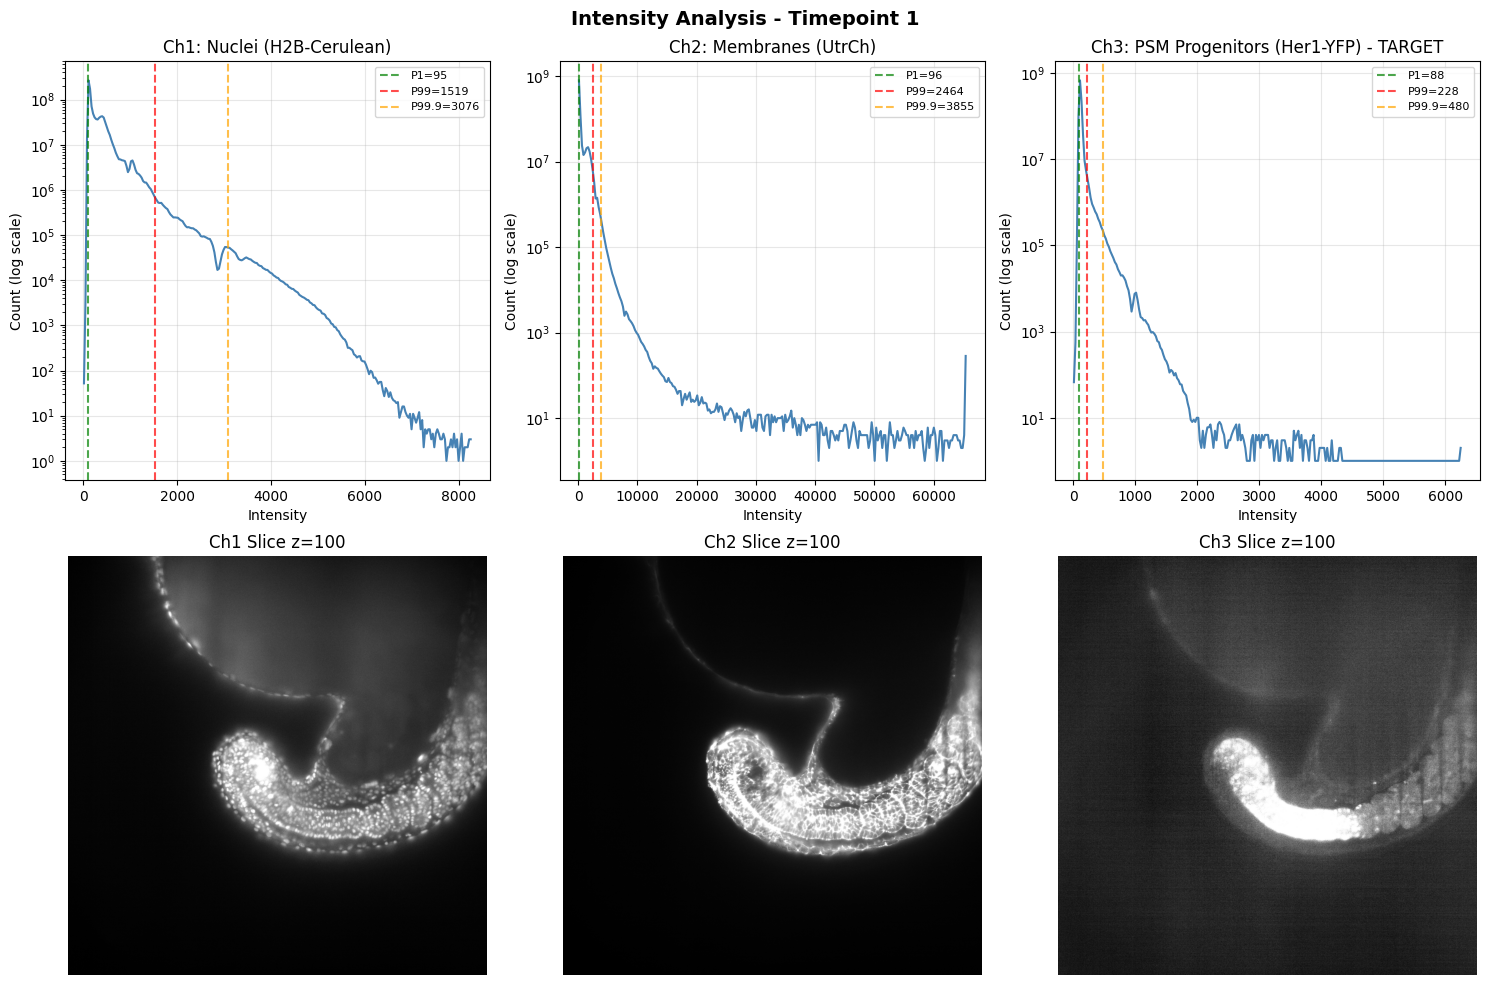


 INTENSITY STATISTICS SUMMARY:

Channel 1 - Nuclei (H2B-Cerulean):
  Range: [0, 8266] (dynamic range: 8266)
  Mean ± Std: 318.8 ± 311.4
  Percentiles: P1=95, P99=1519, P99.9=3076
  SNR estimate: 1.02

Channel 2 - Membranes (UtrCh):
  Range: [15, 65535] (dynamic range: 65520)
  Mean ± Std: 351.9 ± 530.3
  Percentiles: P1=96, P99=2464, P99.9=3855
  SNR estimate: 0.66

Channel 3 - PSM Progenitors (Her1-YFP) - TARGET:
  Range: [11, 6262] (dynamic range: 6251)
  Mean ± Std: 117.7 ± 30.5
  Percentiles: P1=88, P99=228, P99.9=480
  SNR estimate: 3.86


In [4]:
# =============================================================================
# CELL 4: INTENSITY DISTRIBUTION ANALYSIS
# =============================================================================

def analyze_intensity_distribution(
    data_dir: Path,
    timepoint: int = 1,
    n_bins: int = 256,
    log_scale: bool = True
) -> Dict[int, Dict]:
    """
    Analyze intensity distribution for all channels at a given timepoint.
    
    Args:
        data_dir: Dataset directory
        timepoint: Timepoint to analyze
        n_bins: Number of histogram bins
        log_scale: Use log scale for histogram
        
    Returns:
        Dictionary with statistics for each channel
    """
    results = {}
    
    # Detect available channels
    available_channels = []
    for ch in range(1, 5):
        filepath = data_dir / f"t{timepoint:04d}_Channel {ch}.tif"
        if filepath.exists():
            available_channels.append(ch)
    
    n_ch = len(available_channels)
    fig, axes = plt.subplots(2, n_ch, figsize=(5*n_ch, 10))
    if n_ch == 1:
        axes = axes.reshape(2, 1)
    
    for idx, ch in enumerate(available_channels):
        print(f"  Processing Channel {ch}...")
        vol = load_volume_with_test_mode(data_dir, timepoint, ch)
        
        # Calculate statistics
        stats = {
            'mean': float(np.mean(vol)),
            'std': float(np.std(vol)),
            'min': int(np.min(vol)),
            'max': int(np.max(vol)),
            'median': float(np.median(vol)),
            'p1': float(np.percentile(vol, 1)),
            'p5': float(np.percentile(vol, 5)),
            'p95': float(np.percentile(vol, 95)),
            'p99': float(np.percentile(vol, 99)),
            'p999': float(np.percentile(vol, 99.9)),
            'dynamic_range': int(np.max(vol)) - int(np.min(vol)),
            'snr_estimate': float(np.mean(vol)) / (float(np.std(vol)) + 1e-6)
        }
        results[ch] = stats
        
        # Histogram
        ax_hist = axes[0, idx]
        hist, bin_edges = np.histogram(vol.flatten(), bins=n_bins, range=(0, vol.max()))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        if log_scale:
            ax_hist.semilogy(bin_centers, hist + 1, color='steelblue', linewidth=1.5)
        else:
            ax_hist.plot(bin_centers, hist, color='steelblue', linewidth=1.5)
        
        # Add percentile lines
        for p, color, label in [(1, 'green', 'P1'), (99, 'red', 'P99'), (99.9, 'orange', 'P99.9')]:
            pval = stats.get(f'p{p}', np.percentile(vol, p))
            ax_hist.axvline(pval, color=color, linestyle='--', alpha=0.7, label=f'{label}={pval:.0f}')
        
        ax_hist.set_xlabel('Intensity')
        ax_hist.set_ylabel('Count (log scale)' if log_scale else 'Count')
        ax_hist.set_title(f'Ch{ch}: {CHANNEL_NAMES.get(ch, "Unknown")}')
        ax_hist.legend(fontsize=8)
        ax_hist.grid(True, alpha=0.3)
        
        # Sample slice (middle Z)
        ax_img = axes[1, idx]
        mid_z = vol.shape[0] // 2
        vmin, vmax = stats['p1'], stats['p99']
        ax_img.imshow(vol[mid_z], cmap='gray', vmin=vmin, vmax=vmax)
        ax_img.set_title(f'Ch{ch} Slice z={mid_z}')
        ax_img.axis('off')
        
        # Free memory
        del vol
        gc.collect()
    
    plt.suptitle(f'Intensity Analysis - Timepoint {timepoint}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return results


# Run analysis
print(" Analyzing intensity distributions...")
if TEST_MODE:
    print("    TEST MODE: Using cropped volume for quick verification")
try:
    intensity_stats = analyze_intensity_distribution(DATA_DIR, timepoint=TEST_CONFIG.get('timepoint', 1) if TEST_MODE else 1)
    
    print("\n INTENSITY STATISTICS SUMMARY:")
    print("=" * 70)
    for ch, stats in intensity_stats.items():
        print(f"\nChannel {ch} - {CHANNEL_NAMES.get(ch, 'Unknown')}:")
        print(f"  Range: [{stats['min']}, {stats['max']}] (dynamic range: {stats['dynamic_range']})")
        print(f"  Mean ± Std: {stats['mean']:.1f} ± {stats['std']:.1f}")
        print(f"  Percentiles: P1={stats['p1']:.0f}, P99={stats['p99']:.0f}, P99.9={stats['p999']:.0f}")
        print(f"  SNR estimate: {stats['snr_estimate']:.2f}")
except Exception as e:
    print(f"[!] Error: {e}")


 Analyzing Z-profile for Channel 3 (PSM)...


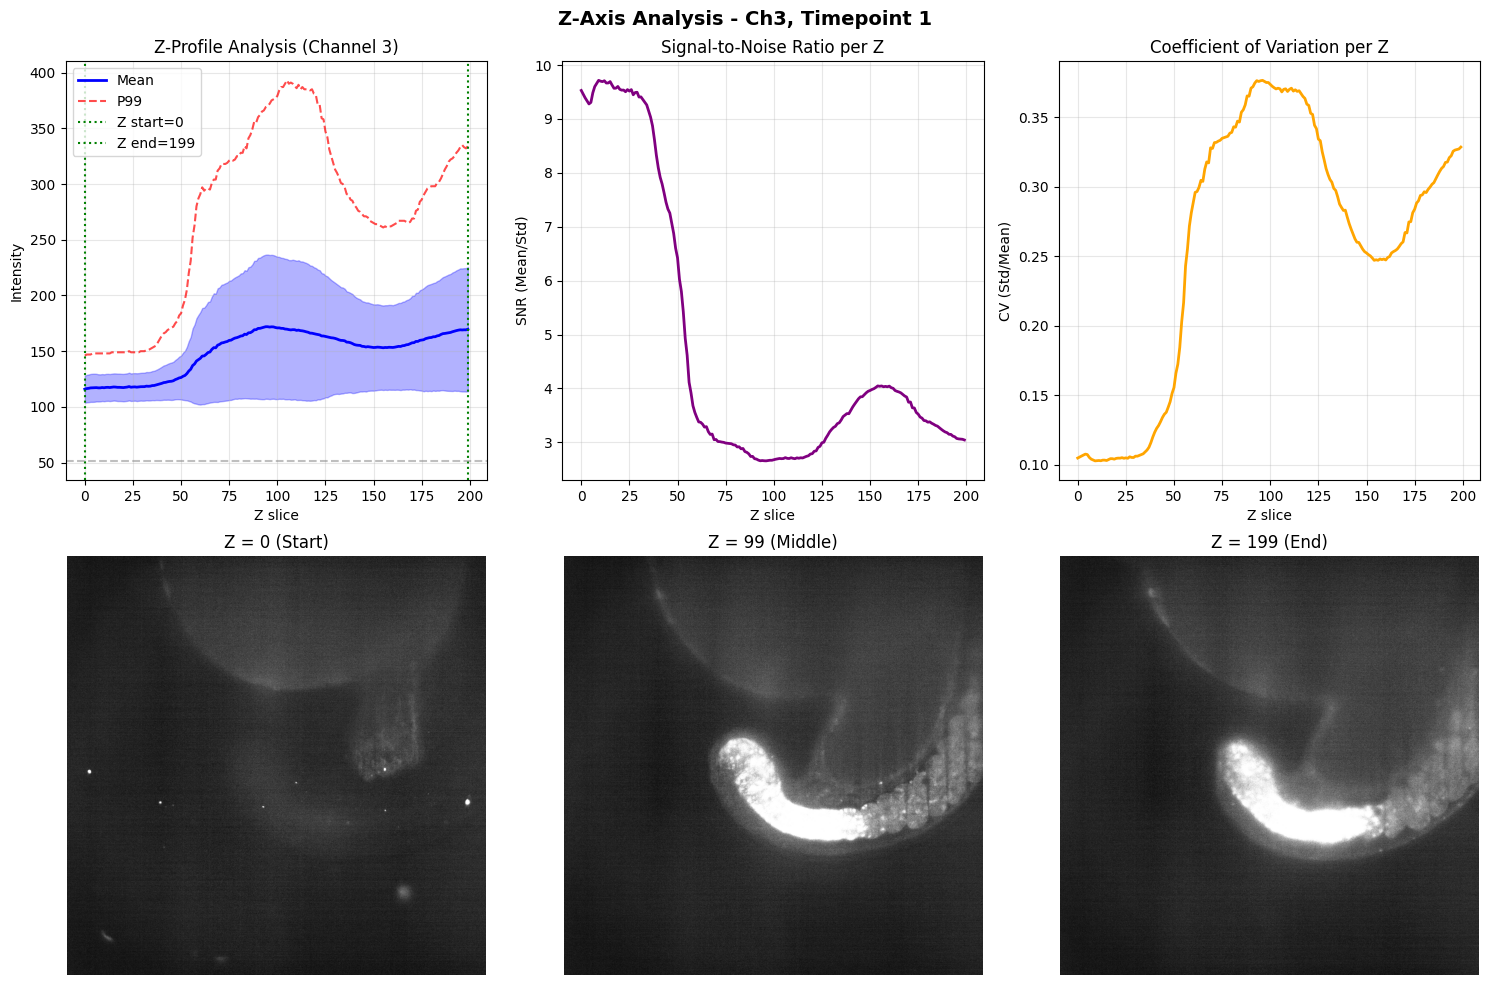


 Z-PROFILE RESULTS (Channel 3):
  Optimal Z range: [0, 199] (200 slices)
  Attenuation ratio (bottom/top): 1.18
  Mean SNR in optimal range: 4.76
  [OK] Z-attenuation is acceptable


In [5]:
# =============================================================================
# CELL 5: Z-PROFILE ANALYSIS (ATTENUATION DETECTION)
# =============================================================================

def analyze_z_profile(
    data_dir: Path,
    timepoint: int = 1,
    channel: int = 3,
    roi_size: int = 500
) -> Dict:
    """
    Analyze how intensity varies with Z depth.
    
    Args:
        data_dir: Dataset directory
        timepoint: Timepoint to analyze
        channel: Channel to analyze (default 3 = PSM)
        roi_size: Size of central ROI for analysis
        
    Returns:
        Dictionary with Z-profile statistics
    """
    vol = load_volume_with_test_mode(data_dir, timepoint, channel)
    Z, H, W = vol.shape
    
    # Central ROI to avoid edge artifacts
    cy, cx = H // 2, W // 2
    half = roi_size // 2
    roi = vol[:, max(0, cy-half):min(H, cy+half), max(0, cx-half):min(W, cx+half)]
    
    # Calculate statistics per Z slice
    z_means = np.array([np.mean(roi[z]) for z in range(Z)])
    z_stds = np.array([np.std(roi[z]) for z in range(Z)])
    z_maxs = np.array([np.max(roi[z]) for z in range(Z)])
    z_p99 = np.array([np.percentile(roi[z], 99) for z in range(Z)])
    
    # Detect optimal Z range (where signal is strong)
    threshold = 0.3 * np.max(z_means)
    valid_z = np.where(z_means > threshold)[0]
    if len(valid_z) > 0:
        z_start, z_end = valid_z[0], valid_z[-1]
    else:
        z_start, z_end = 0, Z - 1
    
    # Detect attenuation
    mid_z = (z_start + z_end) // 2
    mean_top = np.mean(z_means[z_start:mid_z]) if mid_z > z_start else z_means[z_start]
    mean_bottom = np.mean(z_means[mid_z:z_end]) if z_end > mid_z else z_means[z_end]
    attenuation_ratio = mean_bottom / (mean_top + 1e-6)
    
    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Z-profile plot
    ax = axes[0, 0]
    ax.plot(z_means, label='Mean', color='blue', linewidth=2)
    ax.fill_between(range(Z), z_means - z_stds, z_means + z_stds, alpha=0.3, color='blue')
    ax.plot(z_p99, label='P99', color='red', linestyle='--', alpha=0.7)
    ax.axvline(z_start, color='green', linestyle=':', label=f'Z start={z_start}')
    ax.axvline(z_end, color='green', linestyle=':', label=f'Z end={z_end}')
    ax.axhline(threshold, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Z slice')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Z-Profile Analysis (Channel {channel})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # SNR per Z
    ax = axes[0, 1]
    snr = z_means / (z_stds + 1e-6)
    ax.plot(snr, color='purple', linewidth=2)
    ax.set_xlabel('Z slice')
    ax.set_ylabel('SNR (Mean/Std)')
    ax.set_title('Signal-to-Noise Ratio per Z')
    ax.grid(True, alpha=0.3)
    
    # Coefficient of variation per Z
    ax = axes[0, 2]
    cv = z_stds / (z_means + 1e-6)
    ax.plot(cv, color='orange', linewidth=2)
    ax.set_xlabel('Z slice')
    ax.set_ylabel('CV (Std/Mean)')
    ax.set_title('Coefficient of Variation per Z')
    ax.grid(True, alpha=0.3)
    
    # Sample slices
    sample_zs = [z_start, (z_start + z_end) // 2, z_end]
    for idx, z in enumerate(sample_zs):
        ax = axes[1, idx]
        vmin, vmax = np.percentile(vol, [1, 99])
        ax.imshow(vol[z], cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title(f'Z = {z} ({"Start" if idx==0 else "Middle" if idx==1 else "End"})')
        ax.axis('off')
    
    plt.suptitle(f'Z-Axis Analysis - Ch{channel}, Timepoint {timepoint}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    results = {
        'z_range': (z_start, z_end),
        'optimal_z_count': z_end - z_start + 1,
        'attenuation_ratio': attenuation_ratio,
        'has_strong_attenuation': attenuation_ratio < 0.7 or attenuation_ratio > 1.4,
        'mean_snr': float(np.mean(snr[z_start:z_end+1])),
        'z_means': z_means,
        'z_stds': z_stds
    }
    
    print(f"\n Z-PROFILE RESULTS (Channel {channel}):")
    print(f"  Optimal Z range: [{z_start}, {z_end}] ({results['optimal_z_count']} slices)")
    print(f"  Attenuation ratio (bottom/top): {attenuation_ratio:.2f}")
    print(f"  Mean SNR in optimal range: {results['mean_snr']:.2f}")
    
    if results['has_strong_attenuation']:
        print("  [!] DETECTED: Strong Z-attenuation - consider Z-normalization!")
    else:
        print("  [OK] Z-attenuation is acceptable")
    
    del vol, roi
    gc.collect()
    
    return results


# Run Z-profile analysis
print(" Analyzing Z-profile for Channel 3 (PSM)...")
if TEST_MODE:
    print("    TEST MODE: Using cropped volume")
try:
    z_profile_results = analyze_z_profile(DATA_DIR, timepoint=TEST_CONFIG.get('timepoint', 1) if TEST_MODE else 1, channel=3)
except Exception as e:
    print(f"[!] Error: {e}")


 Detecting artifacts in Channel 3...
  Detecting hot pixels...
  Analyzing frequency spectrum for stripes...
  Checking illumination uniformity...


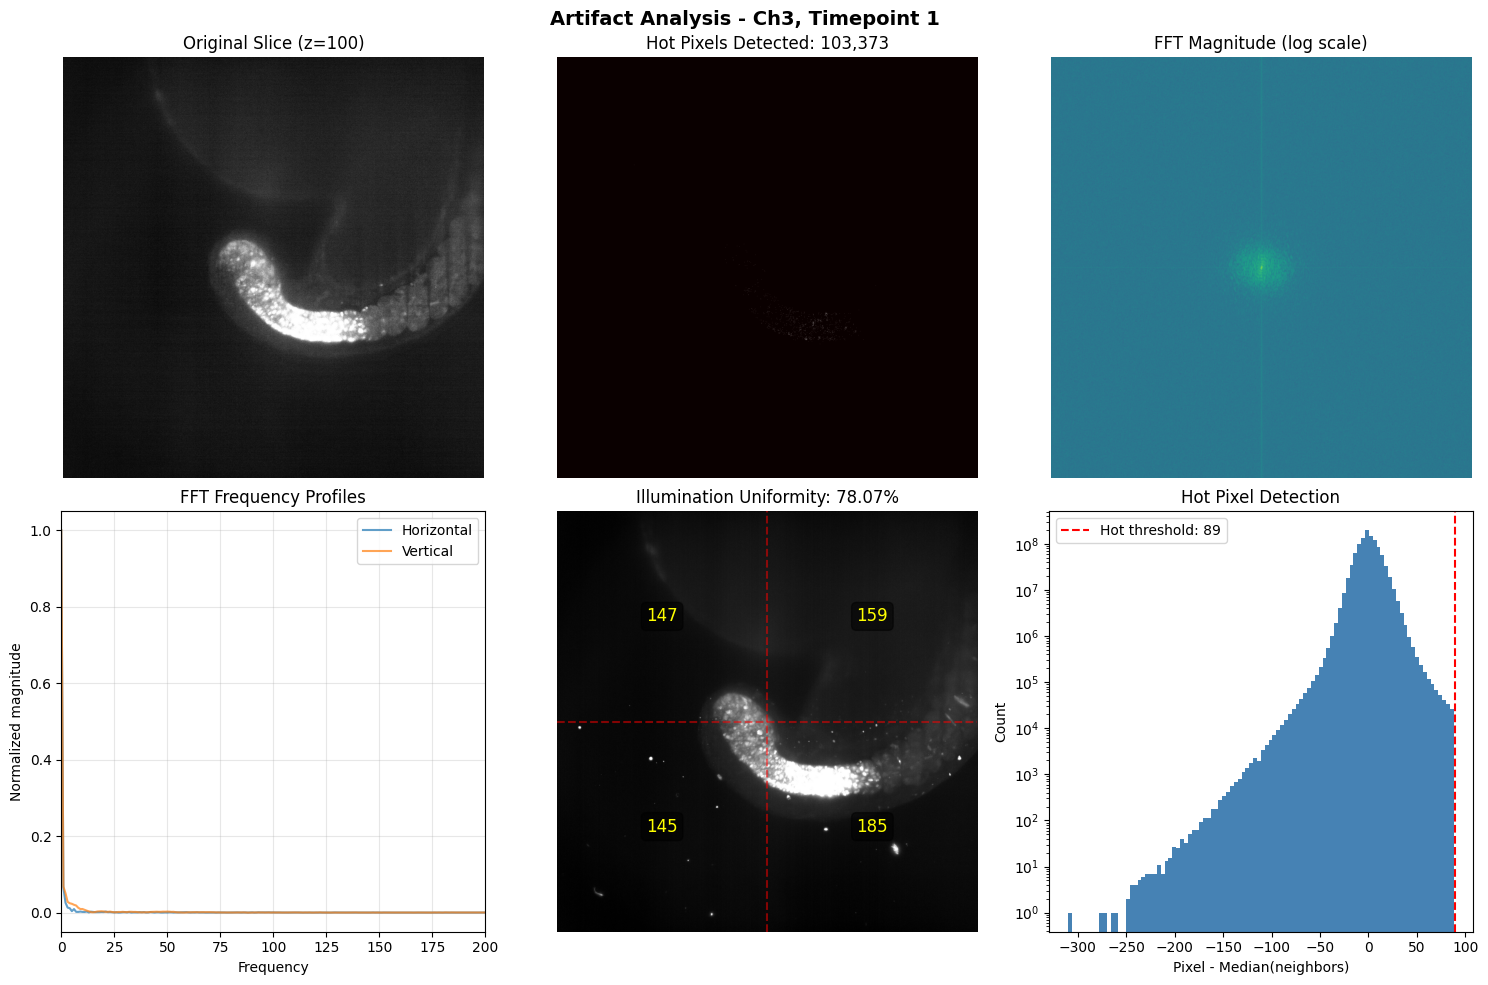


 ARTIFACT ANALYSIS RESULTS:

1. HOT PIXELS:
   Count: 103,373 (9.74e-05 of total)
   [OK] Hot pixel level acceptable

2. STRIPE ARTIFACTS:
   Horizontal frequency peaks: 0
   Vertical frequency peaks: 0
   [OK] No significant stripe patterns detected

3. ILLUMINATION UNIFORMITY:
   Uniformity ratio: 78.07%
   Quadrant means: ['147', '159', '145', '185']
   [OK] Illumination is reasonably uniform


In [6]:
# =============================================================================
# CELL 6: ARTIFACT DETECTION (HOT PIXELS, STRIPES, ILLUMINATION)
# =============================================================================

def detect_artifacts(
    data_dir: Path,
    timepoint: int = 1,
    channel: int = 3
) -> Dict:
    """
    Detect common artifacts in microscopy images.
    
    Args:
        data_dir: Dataset directory
        timepoint: Timepoint to analyze
        channel: Channel to analyze
        
    Returns:
        Dictionary with artifact analysis results
    """
    vol = load_volume_with_test_mode(data_dir, timepoint, channel)
    Z, H, W = vol.shape
    
    results = {}
    vol_float = vol.astype(np.float32)
    
    # 1. Hot pixel detection (extremely bright isolated pixels)
    print("  Detecting hot pixels...")
    median_filtered = ndi.median_filter(vol_float, size=3)
    diff = vol_float - median_filtered
    threshold_hot = np.percentile(diff, 99.99)
    hot_pixels = diff > threshold_hot
    n_hot = np.sum(hot_pixels)
    hot_pixel_ratio = n_hot / vol.size
    
    results['hot_pixels'] = {
        'count': int(n_hot),
        'ratio': float(hot_pixel_ratio),
        'needs_correction': hot_pixel_ratio > 1e-4
    }
    
    # 2. Stripe detection (analyze FFT for periodic patterns)
    print("  Analyzing frequency spectrum for stripes...")
    mid_slice = vol[Z // 2].astype(np.float32)
    fft = np.fft.fft2(mid_slice)
    fft_shift = np.fft.fftshift(fft)
    magnitude = np.abs(fft_shift)
    
    cy, cx = H // 2, W // 2
    h_profile = magnitude[cy, :]  # horizontal frequencies
    v_profile = magnitude[:, cx]  # vertical frequencies
    
    h_norm = h_profile / np.max(h_profile)
    v_norm = v_profile / np.max(v_profile)
    
    h_peaks = np.sum(h_norm[10:W//2-10] > 0.1)
    v_peaks = np.sum(v_norm[10:H//2-10] > 0.1)
    
    results['stripes'] = {
        'horizontal_peaks': int(h_peaks),
        'vertical_peaks': int(v_peaks),
        'likely_striped': h_peaks > 5 or v_peaks > 5
    }
    
    # 3. Illumination uniformity
    print("  Checking illumination uniformity...")
    mip = np.max(vol, axis=0).astype(np.float32)
    
    q1 = mip[:H//2, :W//2]      # top-left
    q2 = mip[:H//2, W//2:]      # top-right
    q3 = mip[H//2:, :W//2]      # bottom-left
    q4 = mip[H//2:, W//2:]      # bottom-right
    
    quadrant_means = [np.mean(q1), np.mean(q2), np.mean(q3), np.mean(q4)]
    uniformity = np.min(quadrant_means) / (np.max(quadrant_means) + 1e-6)
    
    results['illumination'] = {
        'uniformity_ratio': float(uniformity),
        'quadrant_means': quadrant_means,
        'needs_correction': uniformity < 0.7
    }
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original slice
    ax = axes[0, 0]
    vmin, vmax = np.percentile(vol[Z//2], [1, 99])
    ax.imshow(vol[Z // 2], cmap='gray', vmin=vmin, vmax=vmax)
    ax.set_title(f'Original Slice (z={Z//2})')
    ax.axis('off')
    
    # Hot pixel map
    ax = axes[0, 1]
    ax.imshow(hot_pixels[Z // 2], cmap='hot')
    ax.set_title(f'Hot Pixels Detected: {n_hot:,}')
    ax.axis('off')
    
    # FFT magnitude
    ax = axes[0, 2]
    ax.imshow(np.log1p(magnitude), cmap='viridis')
    ax.set_title('FFT Magnitude (log scale)')
    ax.axis('off')
    
    # FFT profiles
    ax = axes[1, 0]
    ax.plot(h_norm[cx:], label='Horizontal', alpha=0.7)
    ax.plot(v_norm[cy:], label='Vertical', alpha=0.7)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Normalized magnitude')
    ax.set_title('FFT Frequency Profiles')
    ax.legend()
    ax.set_xlim(0, 200)
    ax.grid(True, alpha=0.3)
    
    # MIP with quadrant overlay
    ax = axes[1, 1]
    ax.imshow(mip, cmap='gray', vmin=np.percentile(mip, 1), vmax=np.percentile(mip, 99))
    ax.axhline(H//2, color='red', linestyle='--', alpha=0.5)
    ax.axvline(W//2, color='red', linestyle='--', alpha=0.5)
    for i, (qm, pos) in enumerate(zip(quadrant_means, [(H//4, W//4), (H//4, 3*W//4), (3*H//4, W//4), (3*H//4, 3*W//4)])):
        ax.text(pos[1], pos[0], f'{qm:.0f}', color='yellow', fontsize=12, ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
    ax.set_title(f'Illumination Uniformity: {uniformity:.2%}')
    ax.axis('off')
    
    # Histogram of diff (hot pixel detection)
    ax = axes[1, 2]
    diff_flat = diff.flatten()
    ax.hist(diff_flat[diff_flat < threshold_hot], bins=100, color='steelblue', edgecolor='none')
    ax.axvline(threshold_hot, color='red', linestyle='--', label=f'Hot threshold: {threshold_hot:.0f}')
    ax.set_xlabel('Pixel - Median(neighbors)')
    ax.set_ylabel('Count')
    ax.set_title('Hot Pixel Detection')
    ax.legend()
    ax.set_yscale('log')
    
    plt.suptitle(f'Artifact Analysis - Ch{channel}, Timepoint {timepoint}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n ARTIFACT ANALYSIS RESULTS:")
    print("=" * 50)
    
    print(f"\n1. HOT PIXELS:")
    print(f"   Count: {results['hot_pixels']['count']:,} ({results['hot_pixels']['ratio']:.2e} of total)")
    if results['hot_pixels']['needs_correction']:
        print("   [!] RECOMMENDATION: Apply median filter for hot pixel removal")
    else:
        print("   [OK] Hot pixel level acceptable")
    
    print(f"\n2. STRIPE ARTIFACTS:")
    print(f"   Horizontal frequency peaks: {results['stripes']['horizontal_peaks']}")
    print(f"   Vertical frequency peaks: {results['stripes']['vertical_peaks']}")
    if results['stripes']['likely_striped']:
        print("   [!] RECOMMENDATION: Apply stripe correction filter")
    else:
        print("   [OK] No significant stripe patterns detected")
    
    print(f"\n3. ILLUMINATION UNIFORMITY:")
    print(f"   Uniformity ratio: {results['illumination']['uniformity_ratio']:.2%}")
    print(f"   Quadrant means: {[f'{q:.0f}' for q in results['illumination']['quadrant_means']]}")
    if results['illumination']['needs_correction']:
        print("   [!] RECOMMENDATION: Apply illumination correction")
    else:
        print("   [OK] Illumination is reasonably uniform")
    
    del vol, vol_float, median_filtered
    gc.collect()
    
    return results


# Run artifact detection
print(" Detecting artifacts in Channel 3...")
if TEST_MODE:
    print("    TEST MODE: Using cropped volume")
try:
    artifact_results = detect_artifacts(DATA_DIR, timepoint=TEST_CONFIG.get('timepoint', 1) if TEST_MODE else 1, channel=3)
except Exception as e:
    print(f"[!] Error: {e}")


 Comparing all channels...
Found 3 channels: [1, 2, 3]
  Loading Channel 1...
  Loading Channel 2...
  Loading Channel 3...


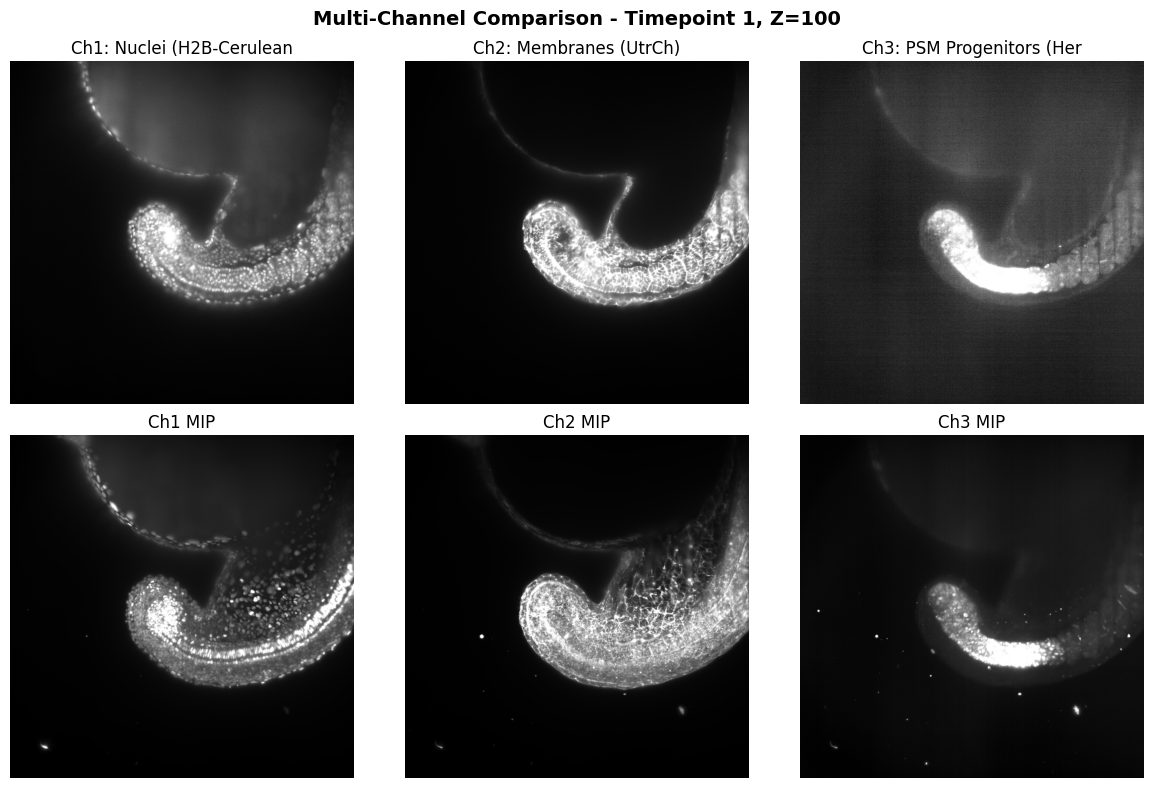

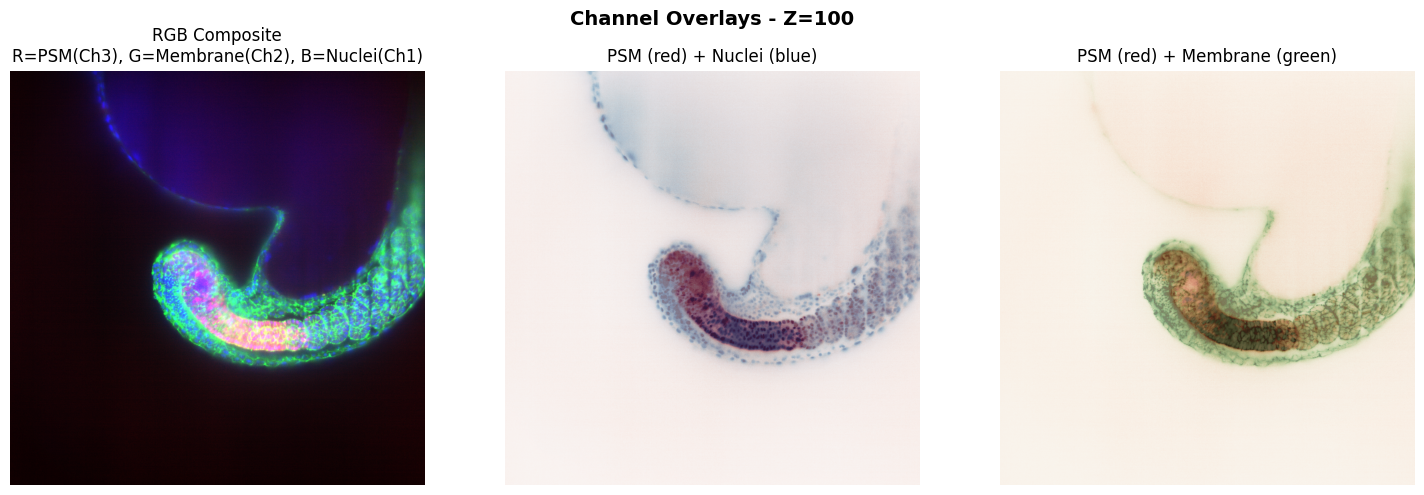


 CHANNEL CORRELATION ANALYSIS:
  Ch1 vs Ch2: r = 0.746
  Ch1 vs Ch3: r = 0.641
  Ch2 vs Ch3: r = 0.583


In [7]:
# =============================================================================
# CELL 7: MULTI-CHANNEL COMPARISON
# =============================================================================

def compare_channels(
    data_dir: Path,
    timepoint: int = 1,
    z_slice: Optional[int] = None
) -> None:
    """
    Visualize all channels side by side and their relationships.
    
    Args:
        data_dir: Dataset directory
        timepoint: Timepoint to analyze
        z_slice: Specific Z slice (None = middle)
    """
    # Detect available channels
    available_channels = []
    for ch in range(1, 5):
        filepath = data_dir / f"t{timepoint:04d}_Channel {ch}.tif"
        if filepath.exists():
            available_channels.append(ch)
    
    n_ch = len(available_channels)
    print(f"Found {n_ch} channels: {available_channels}")
    
    # Load all channels
    volumes = {}
    for ch in available_channels:
        print(f"  Loading Channel {ch}...")
        volumes[ch] = load_volume_with_test_mode(data_dir, timepoint, ch).astype(np.float32)
    
    Z, H, W = volumes[available_channels[0]].shape
    z = z_slice if z_slice is not None else Z // 2
    
    # Figure 1: All channels side by side
    fig, axes = plt.subplots(2, n_ch, figsize=(4*n_ch, 8))
    if n_ch == 1:
        axes = axes.reshape(2, 1)
    
    for idx, ch in enumerate(available_channels):
        vol = volumes[ch]
        vmin, vmax = np.percentile(vol, [1, 99])
        
        # Single slice
        axes[0, idx].imshow(vol[z], cmap='gray', vmin=vmin, vmax=vmax)
        axes[0, idx].set_title(f'Ch{ch}: {CHANNEL_NAMES.get(ch, "Unknown")[:20]}')
        axes[0, idx].axis('off')
        
        # Maximum intensity projection
        mip = np.max(vol, axis=0)
        vmin_mip, vmax_mip = np.percentile(mip, [1, 99])
        axes[1, idx].imshow(mip, cmap='gray', vmin=vmin_mip, vmax=vmax_mip)
        axes[1, idx].set_title(f'Ch{ch} MIP')
        axes[1, idx].axis('off')
    
    plt.suptitle(f'Multi-Channel Comparison - Timepoint {timepoint}, Z={z}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Figure 2: RGB composite (if we have channels 1, 2, 3)
    if 1 in volumes and 2 in volumes and 3 in volumes:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        def norm_channel(img):
            p1, p99 = np.percentile(img, [1, 99])
            img_norm = (img - p1) / (p99 - p1 + 1e-6)
            return np.clip(img_norm, 0, 1)
        
        ch1_norm = norm_channel(volumes[1][z])
        ch2_norm = norm_channel(volumes[2][z])
        ch3_norm = norm_channel(volumes[3][z])
        
        # RGB composite: R=Ch3 (PSM), G=Ch2 (Membrane), B=Ch1 (Nuclei)
        rgb = np.stack([ch3_norm, ch2_norm, ch1_norm], axis=-1)
        
        axes[0].imshow(rgb)
        axes[0].set_title('RGB Composite\nR=PSM(Ch3), G=Membrane(Ch2), B=Nuclei(Ch1)')
        axes[0].axis('off')
        
        # Ch3 with Ch1 overlay
        axes[1].imshow(ch1_norm, cmap='Blues', alpha=1.0)
        axes[1].imshow(ch3_norm, cmap='Reds', alpha=0.5)
        axes[1].set_title('PSM (red) + Nuclei (blue)')
        axes[1].axis('off')
        
        # Ch3 with Ch2 overlay
        axes[2].imshow(ch2_norm, cmap='Greens', alpha=1.0)
        axes[2].imshow(ch3_norm, cmap='Reds', alpha=0.5)
        axes[2].set_title('PSM (red) + Membrane (green)')
        axes[2].axis('off')
        
        plt.suptitle(f'Channel Overlays - Z={z}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # Correlation analysis
    if n_ch >= 2:
        print("\n CHANNEL CORRELATION ANALYSIS:")
        sample_size = min(100000, H * W)
        
        for i, ch1 in enumerate(available_channels):
            for ch2 in available_channels[i+1:]:
                v1 = volumes[ch1][z].flatten()
                v2 = volumes[ch2][z].flatten()
                idx_sample = np.random.choice(len(v1), sample_size, replace=False)
                corr = np.corrcoef(v1[idx_sample], v2[idx_sample])[0, 1]
                print(f"  Ch{ch1} vs Ch{ch2}: r = {corr:.3f}")
    
    # Cleanup
    del volumes
    gc.collect()


# Run channel comparison
print(" Comparing all channels...")
if TEST_MODE:
    print("    TEST MODE: Using cropped volumes")
try:
    compare_channels(DATA_DIR, timepoint=TEST_CONFIG.get('timepoint', 1) if TEST_MODE else 1)
except Exception as e:
    print(f"[!] Error: {e}")


⏱️ Analyzing temporal stability...
Found 218 timepoints for Channel 3
Analyzing timepoints: [1, 32, 63, 94, 125, 156, 187, 218]
  Processing t0001...
  Processing t0032...
  Processing t0063...
  Processing t0094...
  Processing t0125...
  Processing t0156...
  Processing t0187...
  Processing t0218...


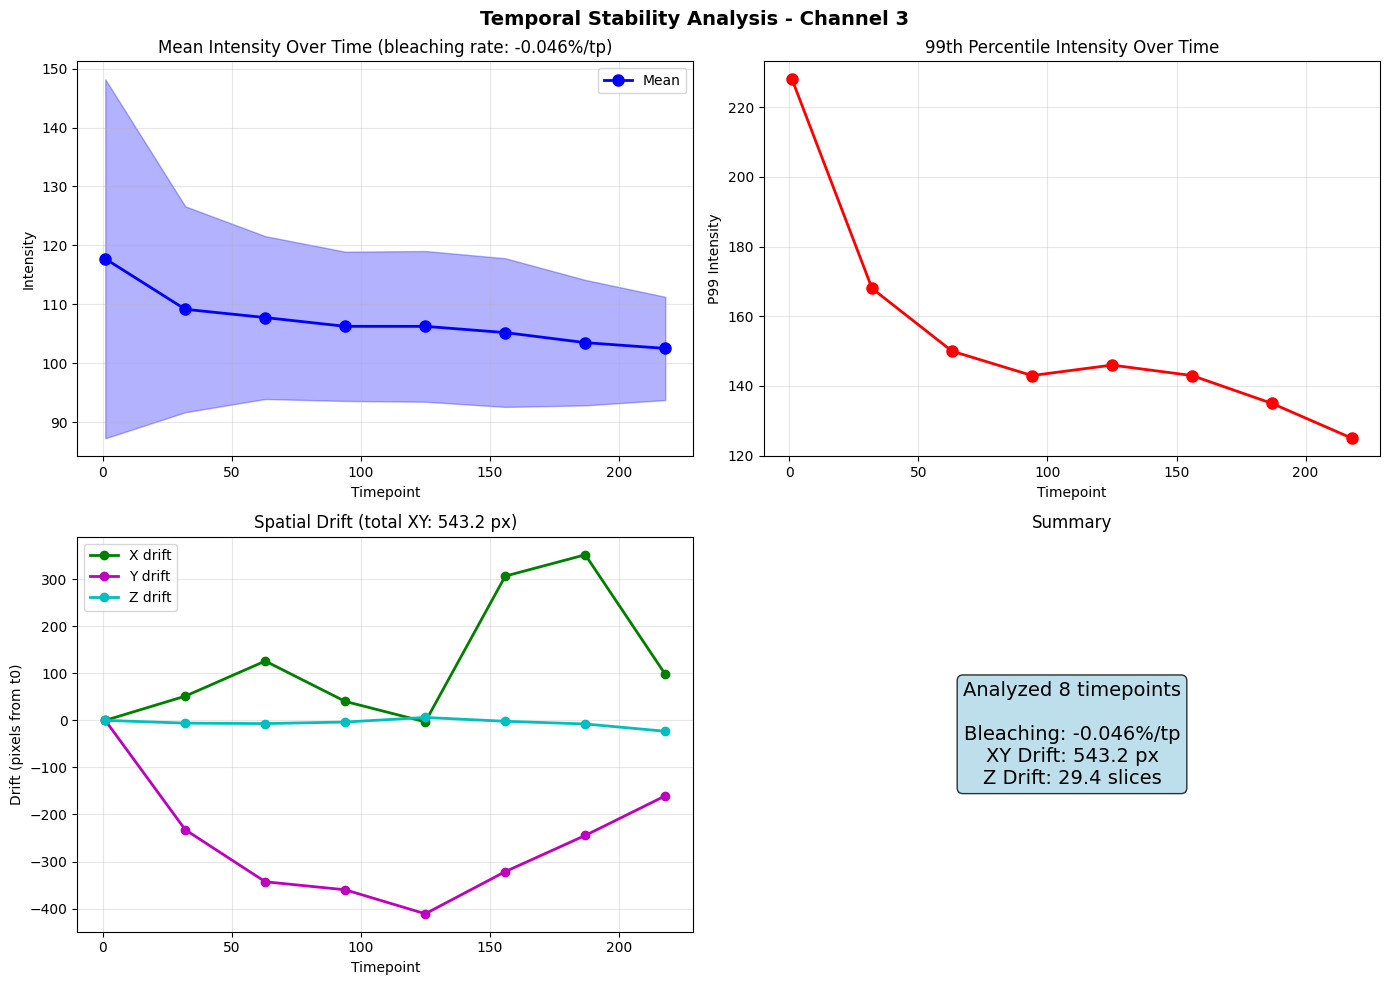


 TEMPORAL STABILITY RESULTS:
  Bleaching rate: -0.046%/timepoint
  [OK] Photobleaching is minimal

  Spatial drift (XY): 543.2 pixels
  Spatial drift (Z): 29.4 slices
  [!] Significant drift detected - consider registration

  Intensity coefficient of variation: 0.041


In [8]:
# =============================================================================
# CELL 8: TEMPORAL STABILITY ANALYSIS
# =============================================================================

def analyze_temporal_stability(
    data_dir: Path,
    channel: int = 3,
    sample_timepoints: List[int] = None,
    max_timepoints: int = 10
) -> Dict:
    """
    Analyze temporal stability of the signal.
    
    Args:
        data_dir: Dataset directory
        channel: Channel to analyze
        sample_timepoints: Specific timepoints to analyze (None = auto-select)
        max_timepoints: Maximum number of timepoints to analyze
        
    Returns:
        Dictionary with temporal analysis results
    """
    # Discover available timepoints
    tiff_files = sorted(data_dir.glob(f"t*_Channel {channel}.tif"))
    available_tps = [int(f.stem.split("_")[0][1:]) for f in tiff_files]
    
    if not available_tps:
        raise FileNotFoundError(f"No files found for channel {channel}")
    
    n_available = len(available_tps)
    print(f"Found {n_available} timepoints for Channel {channel}")
    
    # Select timepoints to analyze
    if sample_timepoints is None:
        if n_available <= max_timepoints:
            sample_timepoints = available_tps
        else:
            indices = np.linspace(0, n_available - 1, max_timepoints, dtype=int)
            sample_timepoints = [available_tps[i] for i in indices]
    
    print(f"Analyzing timepoints: {sample_timepoints}")
    
    # Collect statistics per timepoint
    temporal_stats = {
        'timepoints': [],
        'means': [],
        'stds': [],
        'maxs': [],
        'p99s': [],
        'centroids': []
    }
    
    for t in sample_timepoints:
        print(f"  Processing t{t:04d}...")
        vol = load_volume_with_test_mode(data_dir, t, channel).astype(np.float32)
        
        temporal_stats['timepoints'].append(t)
        temporal_stats['means'].append(np.mean(vol))
        temporal_stats['stds'].append(np.std(vol))
        temporal_stats['maxs'].append(np.max(vol))
        temporal_stats['p99s'].append(np.percentile(vol, 99))
        
        # Calculate intensity centroid
        threshold = np.percentile(vol, 95)
        bright_mask = vol > threshold
        if np.sum(bright_mask) > 0:
            coords = np.where(bright_mask)
            centroid = (np.mean(coords[0]), np.mean(coords[1]), np.mean(coords[2]))
        else:
            centroid = (vol.shape[0]//2, vol.shape[1]//2, vol.shape[2]//2)
        temporal_stats['centroids'].append(centroid)
        
        del vol
        gc.collect()
    
    # Convert to arrays for analysis
    means = np.array(temporal_stats['means'])
    stds_arr = np.array(temporal_stats['stds'])
    p99s = np.array(temporal_stats['p99s'])
    centroids = np.array(temporal_stats['centroids'])
    tps = np.array(temporal_stats['timepoints'])
    
    # Detect photobleaching
    if len(means) > 2:
        slope, _ = np.polyfit(tps, means, 1)
        bleaching_rate = slope / means[0] * 100
    else:
        bleaching_rate = 0
    
    # Detect spatial drift
    if len(centroids) > 1:
        drift_z = np.max(centroids[:, 0]) - np.min(centroids[:, 0])
        drift_y = np.max(centroids[:, 1]) - np.min(centroids[:, 1])
        drift_x = np.max(centroids[:, 2]) - np.min(centroids[:, 2])
        total_drift = np.sqrt(drift_y**2 + drift_x**2)
    else:
        drift_z, drift_y, drift_x, total_drift = 0, 0, 0, 0
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Intensity over time
    ax = axes[0, 0]
    ax.plot(tps, means, 'b-o', label='Mean', linewidth=2, markersize=8)
    ax.fill_between(tps, means - stds_arr, means + stds_arr, alpha=0.3, color='blue')
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Mean Intensity Over Time (bleaching rate: {bleaching_rate:.3f}%/tp)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # P99 over time
    ax = axes[0, 1]
    ax.plot(tps, p99s, 'r-o', linewidth=2, markersize=8)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('P99 Intensity')
    ax.set_title('99th Percentile Intensity Over Time')
    ax.grid(True, alpha=0.3)
    
    # Centroid drift
    ax = axes[1, 0]
    ax.plot(tps, centroids[:, 2] - centroids[0, 2], 'g-o', label='X drift', linewidth=2)
    ax.plot(tps, centroids[:, 1] - centroids[0, 1], 'm-o', label='Y drift', linewidth=2)
    ax.plot(tps, centroids[:, 0] - centroids[0, 0], 'c-o', label='Z drift', linewidth=2)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Drift (pixels from t0)')
    ax.set_title(f'Spatial Drift (total XY: {total_drift:.1f} px)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Sample images placeholder
    ax = axes[1, 1]
    ax.text(0.5, 0.5, f'Analyzed {len(sample_timepoints)} timepoints\n\n'
            f'Bleaching: {bleaching_rate:.3f}%/tp\n'
            f'XY Drift: {total_drift:.1f} px\n'
            f'Z Drift: {drift_z:.1f} slices',
            transform=ax.transAxes, ha='center', va='center', fontsize=14,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    ax.axis('off')
    ax.set_title('Summary')
    
    plt.suptitle(f'Temporal Stability Analysis - Channel {channel}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Results summary
    results = {
        'n_timepoints_analyzed': len(sample_timepoints),
        'bleaching_rate_pct_per_tp': float(bleaching_rate),
        'has_significant_bleaching': abs(bleaching_rate) > 0.5,
        'total_xy_drift_px': float(total_drift),
        'total_z_drift_px': float(drift_z),
        'has_significant_drift': total_drift > 20,
        'intensity_cv': float(np.std(means) / np.mean(means))
    }
    
    print("\n TEMPORAL STABILITY RESULTS:")
    print("=" * 50)
    print(f"  Bleaching rate: {results['bleaching_rate_pct_per_tp']:.3f}%/timepoint")
    if results['has_significant_bleaching']:
        print("  [!] Significant photobleaching detected - consider intensity normalization")
    else:
        print("  [OK] Photobleaching is minimal")
    
    print(f"\n  Spatial drift (XY): {results['total_xy_drift_px']:.1f} pixels")
    print(f"  Spatial drift (Z): {results['total_z_drift_px']:.1f} slices")
    if results['has_significant_drift']:
        print("  [!] Significant drift detected - consider registration")
    else:
        print("  [OK] Spatial drift is acceptable")
    
    print(f"\n  Intensity coefficient of variation: {results['intensity_cv']:.3f}")
    
    return results


# Run temporal analysis
print("⏱️ Analyzing temporal stability...")

# Check if we should skip in test mode
if TEST_MODE and TEST_CONFIG.get('skip_temporal', True):
    print("    TEST MODE: Skipping temporal analysis (set skip_temporal=False to enable)")
    print("    Temporal analysis takes ~5-15 min on full dataset")
    temporal_results = None
else:
    if TEST_MODE:
        print(f"    TEST MODE: Using only {TEST_CONFIG.get('n_temporal_samples', 3)} timepoints")
    try:
        max_tp = TEST_CONFIG.get('n_temporal_samples', 3) if TEST_MODE else 8
        temporal_results = analyze_temporal_stability(DATA_DIR, channel=3, max_timepoints=max_tp)
    except Exception as e:
        print(f"[!] Error: {e}")
        temporal_results = None


In [9]:
# =============================================================================
# CELL 9: EXPLORATION SUMMARY
# =============================================================================

def generate_recommendations() -> None:
    """Print preprocessing recommendations."""
    print("=" * 70)
    print("DATA EXPLORATION SUMMARY")
    print("=" * 70)
    
    print("""
Recommended preprocessing steps:

1. Intensity normalization (percentile clipping 1-99.5%)
2. Background subtraction (rolling ball r=50-100)
3. Noise reduction (Gaussian, anisotropic sigma)
4. Z-attenuation correction (if needed)

For Channel 3 (PSM):
  a) Hot pixel removal (median filter)
  b) Background subtraction
  c) Z-correction
  d) Gaussian smoothing
  e) Normalization
""")
    print("=" * 70)


generate_recommendations()


In [10]:
# =============================================================================
# CELL 10: QUICK SINGLE-SLICE VISUALIZATION (UTILITY)
# =============================================================================

def quick_view(
    data_dir: Path,
    timepoint: int = 1,
    z_slice: Optional[int] = None,
    channel: int = 3
) -> None:
    """
    Quick visualization of a single slice for rapid inspection.
    
    Args:
        data_dir: Dataset directory
        timepoint: Timepoint to view
        z_slice: Z slice to view (None = middle)
        channel: Channel to view
    """
    vol = load_volume_with_test_mode(data_dir, timepoint, channel)
    z = z_slice if z_slice is not None else vol.shape[0] // 2
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Raw slice
    vmin, vmax = np.percentile(vol[z], [1, 99])
    axes[0].imshow(vol[z], cmap='gray', vmin=vmin, vmax=vmax)
    axes[0].set_title(f'Slice z={z} (P1-P99 stretch)')
    axes[0].axis('off')
    
    # Enhanced contrast
    vmin2, vmax2 = np.percentile(vol[z], [5, 99.5])
    axes[1].imshow(vol[z], cmap='gray', vmin=vmin2, vmax=vmax2)
    axes[1].set_title(f'Enhanced contrast (P5-P99.5)')
    axes[1].axis('off')
    
    # MIP
    mip = np.max(vol, axis=0)
    vmin_mip, vmax_mip = np.percentile(mip, [1, 99])
    axes[2].imshow(mip, cmap='gray', vmin=vmin_mip, vmax=vmax_mip)
    axes[2].set_title('Maximum Intensity Projection (MIP)')
    axes[2].axis('off')
    
    plt.suptitle(f'Quick View - t{timepoint:04d}, Channel {channel}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print(f"Volume shape: {vol.shape}")
    print(f"Value range: [{vol.min()}, {vol.max()}]")
    print(f"Mean: {vol.mean():.1f}, Std: {vol.std():.1f}")
    
    del vol
    gc.collect()


# Uncomment the line below to run quick view
# quick_view(DATA_DIR, timepoint=1, channel=3)


In [1]:
import platform
import os

print("=== SYSTEM INFO ===")
print(f"CPU: {platform.processor()}")
print(f"Machine: {platform.machine()}")
print(f"OS: {platform.system()} {platform.release()}")

# RAM
try:
    import psutil
    ram = psutil.virtual_memory().total / (1024**3)
    print(f"RAM: {ram:.1f} GB")
except:
    # Linux alternative
    with open('/proc/meminfo') as f:
        for line in f:
            if 'MemTotal' in line:
                ram_kb = int(line.split()[1])
                print(f"RAM: {ram_kb / (1024**2):.1f} GB")
                break

# CPU info on Linux
try:
    with open('/proc/cpuinfo') as f:
        for line in f:
            if 'model name' in line:
                print(f"CPU Model: {line.split(':')[1].strip()}")
                break
except:
    pass

print(f"Hostname: {platform.node()}")

=== SYSTEM INFO ===
CPU: 
Machine: x86_64
OS: Linux 6.8.0-59-generic
RAM: 1007.6 GB
CPU Model: AMD EPYC 7543 32-Core Processor
Hostname: santiago-0-0


In [2]:
# GPU Info
print("=== GPU INFO ===")
try:
    import torch
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
        print(f"CUDA Version: {torch.version.cuda}")
    else:
        print("No CUDA GPU available")
except:
    print("PyTorch not installed")

# Alternative with nvidia-smi
import subprocess
try:
    result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv'], 
                          capture_output=True, text=True)
    print(f"\nnvidia-smi output:\n{result.stdout}")
except:
    print("nvidia-smi not available (no NVIDIA GPU or drivers)")

=== GPU INFO ===
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 14.9 GB
CUDA Version: 12.8

nvidia-smi output:
name, memory.total [MiB]
NVIDIA A100-SXM4-80GB, 15259 MiB



In [4]:
import os

# List files in current directory
print("Current directory:", os.getcwd())
print("\nFiles here:")
for f in os.listdir('.'):
    print(f"  {f}")

# Check parent directory for data
print("\nParent directory:")
for f in os.listdir('..'):
    print(f"  {f}")

Current directory: /data/241211-Her1YFPxUtrCh+H2BCer-HIGHRES/20241211_181907_Experiment/Position 3_Settings 1

Files here:
  t0001_Channel 1.tif
  t0001_Channel 2.tif
  t0001_Channel 3.tif
  ome-tiff.companion.ome
  t0002_Channel 1.tif
  t0002_Channel 2.tif
  t0002_Channel 3.tif
  t0003_Channel 1.tif
  t0003_Channel 2.tif
  t0003_Channel 3.tif
  t0004_Channel 1.tif
  t0004_Channel 2.tif
  t0004_Channel 3.tif
  t0005_Channel 1.tif
  t0005_Channel 2.tif
  t0005_Channel 3.tif
  t0006_Channel 1.tif
  t0006_Channel 2.tif
  t0006_Channel 3.tif
  t0007_Channel 1.tif
  t0007_Channel 2.tif
  t0007_Channel 3.tif
  t0008_Channel 1.tif
  t0008_Channel 2.tif
  t0008_Channel 3.tif
  t0009_Channel 1.tif
  t0009_Channel 2.tif
  t0009_Channel 3.tif
  t0010_Channel 1.tif
  t0010_Channel 2.tif
  t0010_Channel 3.tif
  t0011_Channel 1.tif
  t0011_Channel 2.tif
  t0011_Channel 3.tif
  t0012_Channel 1.tif
  t0012_Channel 2.tif
  t0012_Channel 3.tif
  t0013_Channel 1.tif
  t0013_Channel 2.tif
  t0013_Channel 

Data shape: (200, 2304, 2304)
Slice shape: (576, 576)


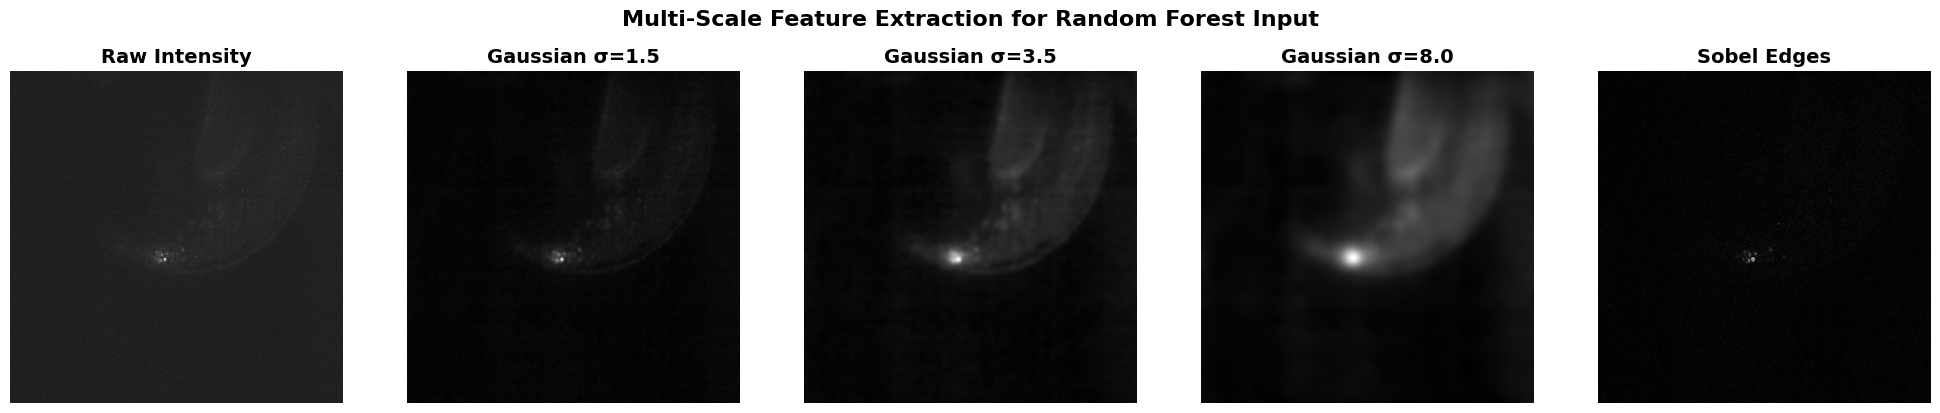


[OK] Saved: feature_visualization.png


In [5]:
import numpy as np
import tifffile
from skimage.filters import gaussian, sobel
import matplotlib.pyplot as plt

# Load one slice from Channel 3 (PSM marker)
data = tifffile.imread("t0100_Channel 3.tif")
print(f"Data shape: {data.shape}")

# Take middle Z slice, downscaled
z_mid = data.shape[0] // 2
slice_2d = data[z_mid, ::4, ::4].astype(np.float32)
print(f"Slice shape: {slice_2d.shape}")

# Compute features
features = {
    'Raw Intensity': slice_2d,
    'Gaussian σ=1.5': gaussian(slice_2d, sigma=1.5),
    'Gaussian σ=3.5': gaussian(slice_2d, sigma=3.5),
    'Gaussian σ=8.0': gaussian(slice_2d, sigma=8.0),
    'Sobel Edges': sobel(slice_2d)
}

# Plot and save
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, (name, img) in zip(axes, features.items()):
    ax.imshow(img, cmap='gray')
    ax.set_title(name, fontsize=14, fontweight='bold')
    ax.axis('off')

plt.suptitle('Multi-Scale Feature Extraction for Random Forest Input', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('feature_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n[OK] Saved: feature_visualization.png")
